In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
from scipy.optimize import curve_fit
import scipy.signal as scs
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Set the style of seaborn for better looking plots
sns.set()

# Data

In [3]:
ts = pd.read_csv('Reykjavik.csv')
ts

,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),...,sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),et0_fao_evapotranspiration (mm)
0,1/1/40,73,2.2,-1.7,0.3,-3.2,-6.8,-4.8,1940-01-01T11:18,1940-01-01T15:42,...,NaN,NaN,NaN,NaN,11,22.3,NaN,73,NaN,NaN
1,1/2/40,73,1.0,-0.4,0.3,-4.0,-5.9,-4.9,1940-01-02T11:17,1940-01-02T15:44,...,0.00,3.7,0.1,2.52,23,19.8,39.6,77,0.09,0.44
2,1/3/40,73,4.0,-0.4,1.9,1.2,-6.3,-3.1,1940-01-03T11:16,1940-01-03T15:46,...,0.00,5.0,1.2,2.66,16,30.0,54.0,102,0.10,0.27
3,1/4/40,53,5.4,1.5,2.5,1.5,-2.1,-1.3,1940-01-04T11:15,1940-01-04T15:48,...,828.68,2.1,2.1,0.00,12,21.1,27.7,150,0.20,0.02
4,1/5/40,55,6.5,4.6,5.6,1.8,0.2,1.2,1940-01-05T11:13,1940-01-05T15:50,...,0.00,5.5,5.5,0.00,11,29.9,52.9,148,0.16,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30950,9/26/24,3,5.1,-1.1,2.4,2.2,-4.2,-0.5,2024-09-26T07:23,2024-09-26T19:12,...,13904.13,0.0,0.0,0.00,0,9.4,20.2,318,5.18,0.60
30951,9/27/24,51,7.2,3.6,5.2,5.1,1.2,3.1,2024-09-27T07:26,2024-09-27T19:09,...,4209.56,1.1,1.1,0.00,11,11.8,21.2,92,4.15,0.56
30952,9/28/24,53,5.9,3.8,5.0,2.7,-0.1,1.4,2024-09-28T07:29,2024-09-28T19:05,...,0.00,4.2,4.2,0.00,16,16.8,31.7,103,1.70,0.45
30953,9/29/24,53,8.0,2.1,5.3,6.1,-1.6,2.1,2024-09-29T07:32,2024-09-29T19:02,...,7455.96,4.4,4.4,0.00,13,17.3,32.4,66,3.90,0.52


In [4]:
num_years = 84
temp_mean = ts['temperature_2m_mean (°C)'].iloc[:num_years*365]
t = ts['time']
t_90s= [t[i][:-2]+str(1900+ int(t[i][-2:])) for i in range(365*60+14)]
t_20s= [t[i][:-2]+str(2000+ int(t[i][-2:])) for i in range(365*60+15,len(t))]
time = t_90s + t_20s
time = time[:num_years*365]
time = pd.to_datetime(time)

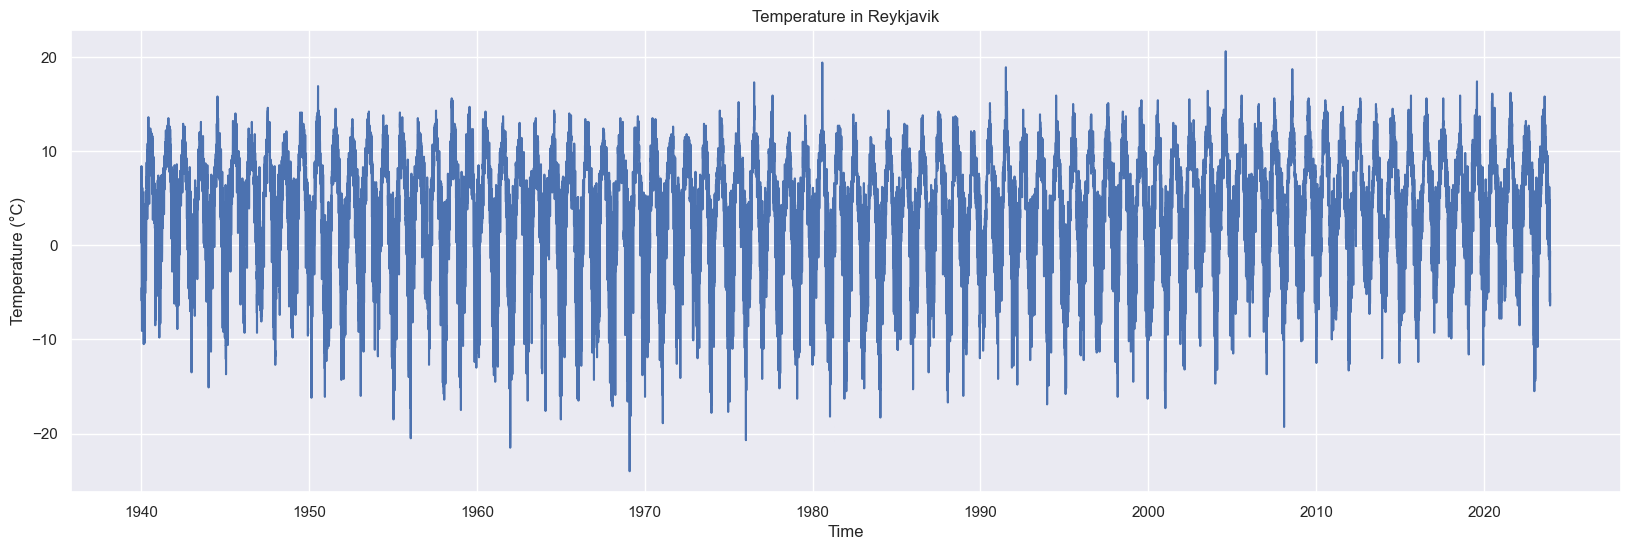

In [5]:
# Plot the time series, grouped by year on the x axis
plt.figure(figsize=(20, 6))
plt.plot(time, temp_mean)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.show()

# Trend Estimation with MA filter

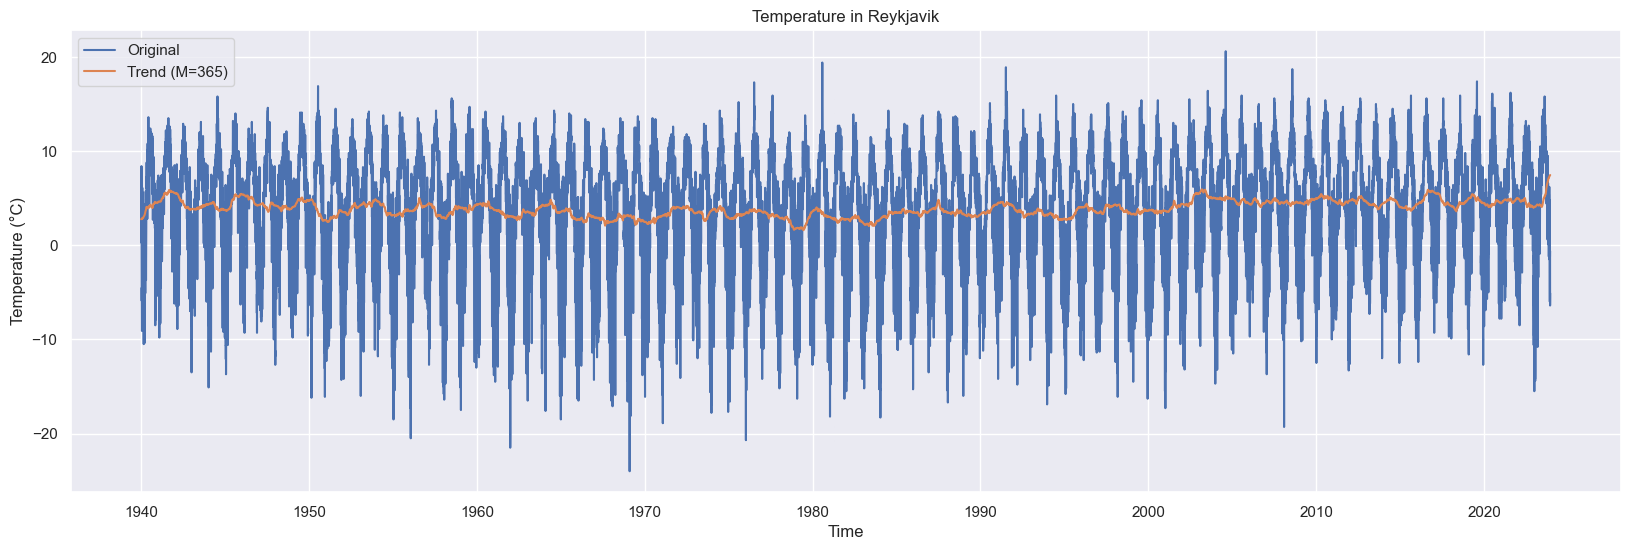

In [6]:
def maSmooth(TSeries,omega,data_aug=False):
    M=omega.shape[0]
    lag=int(np.floor((M-1)/2))
    
    if data_aug: #If smooted TS should have the same number of samples
        #TSeriesAug=TSeries._append(np.flip(TSeries[-lag:]))
        TSeriesAug=pd.concat([TSeries,np.flip(TSeries[-lag:])])
        TSeriesAug=pd.concat([np.flip(TSeries[0:lag]),TSeriesAug])
        #TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)
        
    else:
        TSeriesAug=TSeries
        
    nf=range(lag,TSeriesAug.size-lag)
    xf=np.zeros(TSeriesAug.size-2*(lag)).astype('float')
    for n in nf:
        xf[n-lag]=(1/float(sum(omega)))*np.sum(np.multiply(TSeriesAug[n-lag:n+lag+1],omega))
    xf=pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size-lag],name="Smoothed TS with M="+str(M))
    
    return xf

# Define the moving average filter
M = 365
omega = np.ones(M) * (1 / float(M))

# Apply the moving average filter
Trend = maSmooth(temp_mean, omega, data_aug=True)

# Plot the original time series and the smoothed time series
plt.figure(figsize=(20, 6))

# Plot original time series
plt.plot(time, temp_mean, label='Original')

# Adjust the time index for the smoothed series
#lag = int(np.floor((M - 1) / 2))
#adjusted_time = time[lag:-lag]  # Adjust time to match smoothed series length

# Plot the smoothed time series with the adjusted time index
plt.plot(time, Trend, label='Trend (M=365)')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.legend()
plt.show()



# Trend Estimation with LOWESS

/tmp/ipykernel_19882/2389570989.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xf[k]=res_wls.params[1]*k+res_wls.params[0]


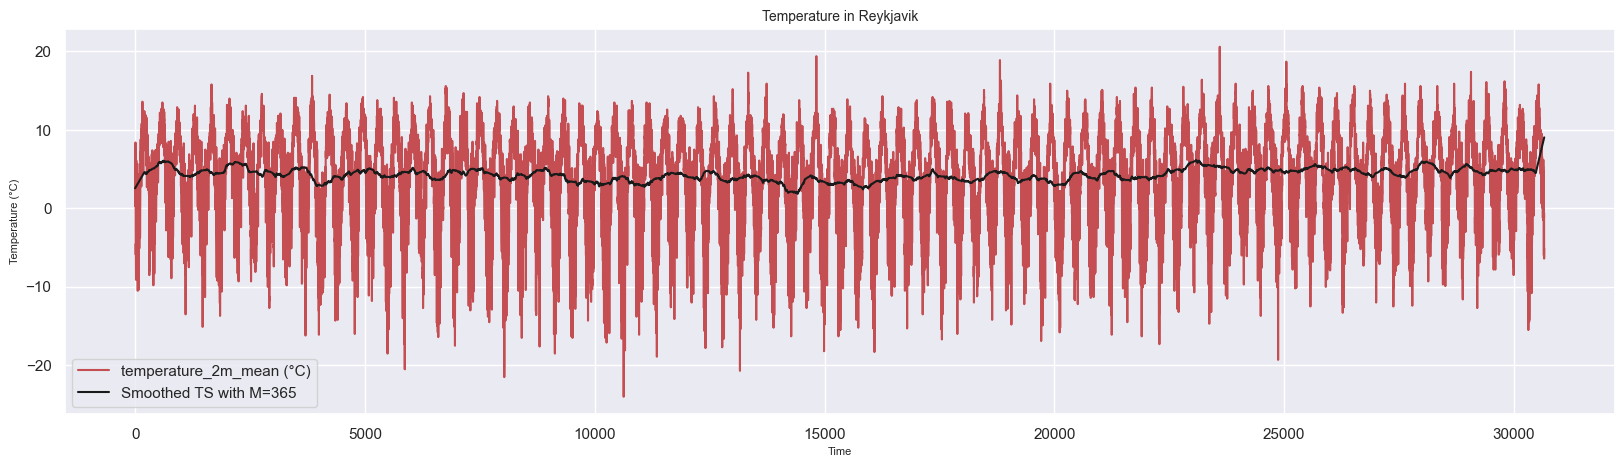

In [7]:
def flin(x,a,b):
    return a*x+b

def xWeights(x,xi,span):
    wi=(1-abs((x-xi)/float(span))**3)**3
    #plt.figure()
    #plt.plot(wi)
    return wi

def yWeights(ri,MAD):
    if np.abs(ri)<6*MAD:
        return (1-((ri/(6*MAD))**2))**2
    else:
        return 0


def loessPass(TSeries,TSeriesE=pd.Series(np.array([])),span=5,timePass=True):
    lag=int((span-1)/2)
    xf=np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k<=lag:
            win=TSeries[0:span]
            if not timePass:
                winE=TSeriesE[0:span]
            xvs=np.array(range(span))
            #print "No inicio"
        elif k>TSeries.size-lag:
            #print "No fim"
            win=TSeries[TSeries.size-span:TSeries.size]
            if not timePass:
                winE=TSeriesE[TSeriesE.size-span:TSeriesE.size]
            xvs=np.array(range(TSeries.size-span,TSeries.size))
        else:
            #print "No meio"
            win=TSeries[k-lag-1:k+lag]
            if not timePass:
                winE=TSeriesE[k-lag-1:k+lag]
            xvs=np.array(range(k-lag,k+lag+1))

        ws=np.zeros(span).astype('float')
            
        if not timePass:
            res=np.array(win-winE)
            #res=res.as_matrix()
            MAD=np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(k,xvs[xw],np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1]))))
            else:
                ws[xw]=yWeights(res[xw],MAD)
            #print np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1])))
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k]=res_wls.params[1]*k+res_wls.params[0]
    return xf

def lowess(TSeries,span=5,ftype='linear'):
    
    xf=loessPass(TSeries,span=span,timePass=True)
    xf=loessPass(TSeries,TSeriesE=pd.Series(data=xf, index=TSeries.index),span=span,timePass=False)
    xf=pd.Series(data=xf, index=TSeries.index,name="Smoothed TS with M="+str(M))
    return xf


# apply smooth 13 
M=365
Trend = lowess(temp_mean,span=M)

# Create a new figure with a specific size (width, height)
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width as needed

temp_mean.plot(ax=ax, color='r', legend=True)
Trend.plot(ax=ax, color='k', legend=True)
ax.set_ylabel('Temperature (°C)', fontdict={'fontsize':8})
ax.set_xlabel('Time', fontdict={'fontsize':8})
ax.set_title('Temperature in Reykjavik', fontdict={'fontsize':10})

plt.show()

# Seasonality Estimation Butter Filter

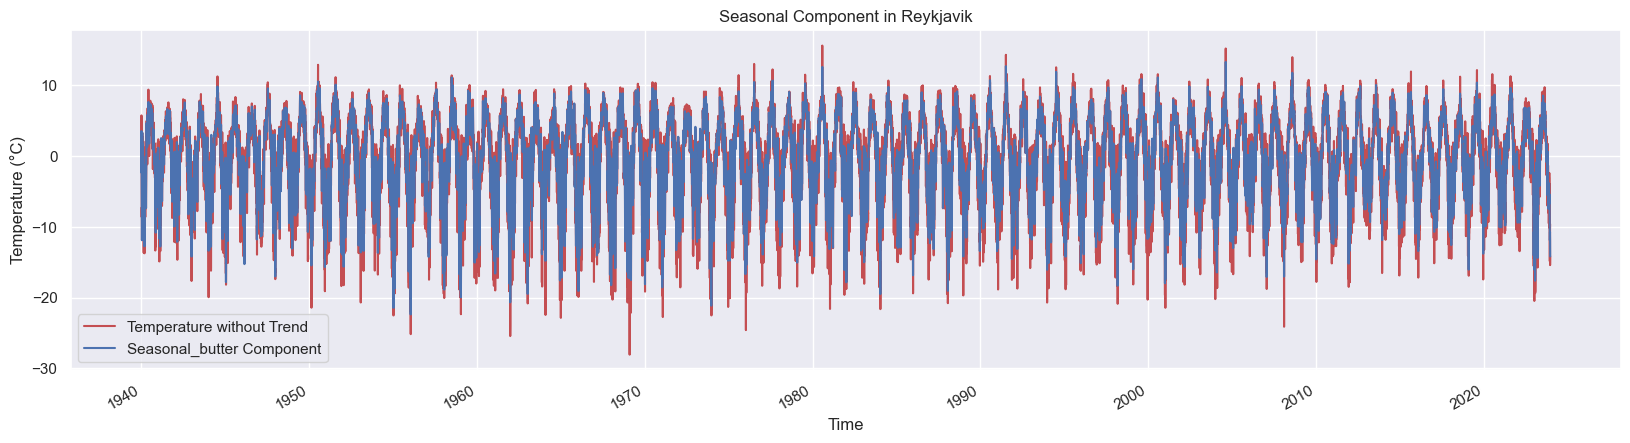

In [8]:
temp_mean_no_trend = temp_mean - Trend

# Estimate the seasonal component with butter filter
sos=scs.butter(N=5,fs=12,Wn=[1.4],btype='lowpass',output='sos')
Seasonal = scs.sosfiltfilt(sos,temp_mean_no_trend)

# Create a new figure with a specific size (width, height)
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width as needed

Seasonal_butter = pd.Series(data=Seasonal,index=time,name="Seasonal_butter Component")
temp_mean_no_trend = pd.Series(data=temp_mean_no_trend.values,index=time,name="Temperature without Trend")
temp_mean_no_trend.plot(ax=ax, color='r', legend=True)
Seasonal_butter.plot(legend=True)
# plot temp_mean_no_trend
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Seasonal Component in Reykjavik')
plt.show()

# Remove seasonal component from temp_mean_no_trend
temp_mean_no_trend_no_season = temp_mean_no_trend - Seasonal_butter



# Seasonalty by Epoch Averaging

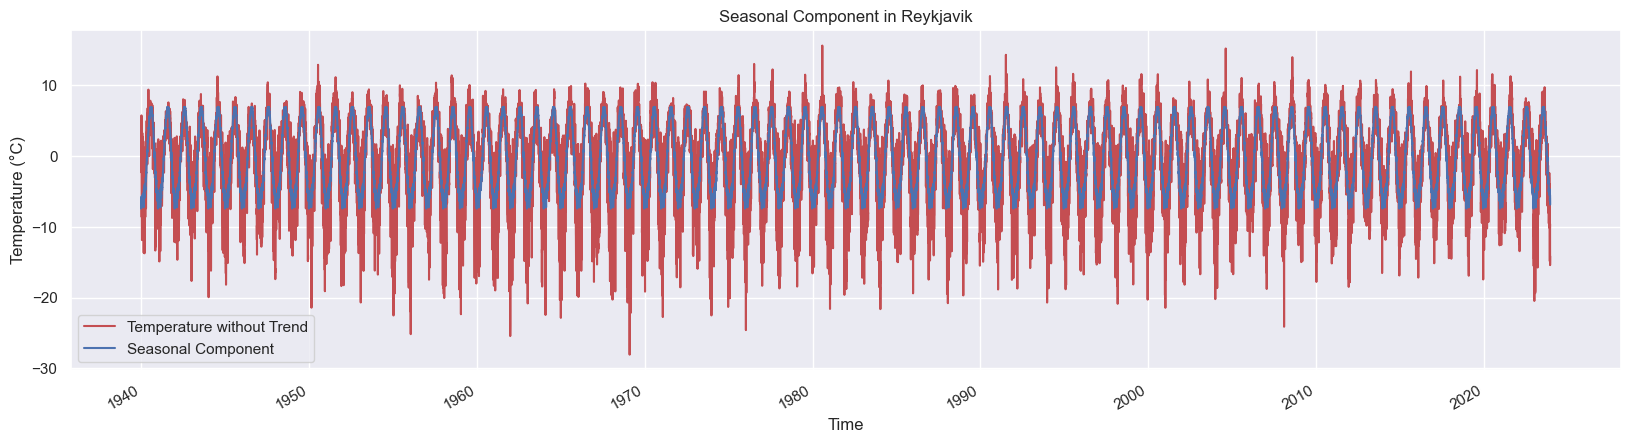

Text(0.5, 0, 'Time (Years)')

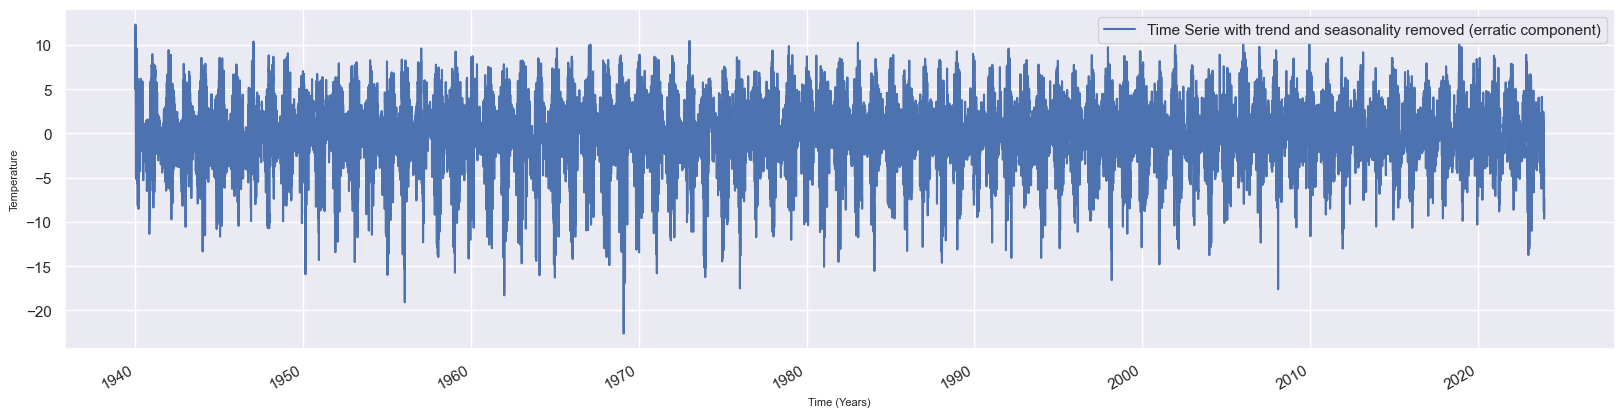

In [9]:
S=365

N=temp_mean_no_trend.size

C=int(np.floor(N/S))

reshTS=np.array(temp_mean_no_trend).reshape((C,S)) #Reshape 1 column per month

ac=np.tile(np.mean(reshTS,axis=0),(C,))
temp=temp_mean_no_trend[0:C*S]
SeaTS=pd.Series(data=ac,index=temp_mean_no_trend.index,name="Seasonal Component")
fig, ax = plt.subplots(figsize=(20, 5))
# plot temp and seasonal component in the same plot
temp.plot(ax=ax, color='r', legend=True)
SeaTS.plot(legend=True)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Seasonal Component in Reykjavik')
plt.show()

#Remove seasonal component by assuming the additive model
psNoTrendNoSeas=temp-SeaTS
psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"

fig, ax = plt.subplots(figsize=(20, 5))
ax=psNoTrendNoSeas.plot(legend=True)
ax.set_ylabel('Temperature',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

# Residual component

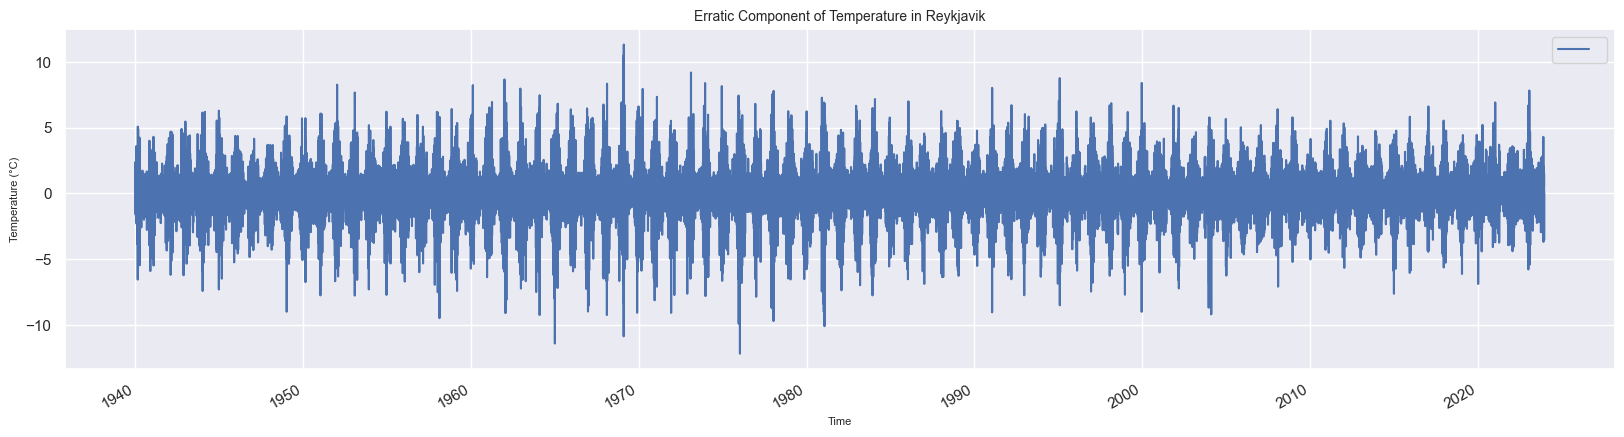

In [10]:
# Create a new figure with a specific size (width, height)
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width as needed

temp_mean_no_trend_no_season.plot(ax=ax, color='b', legend=True)
ax.set_ylabel('Temperature (°C)', fontdict={'fontsize':8})
ax.set_xlabel('Time', fontdict={'fontsize':8})
ax.set_title('Erratic Component of Temperature in Reykjavik', fontdict={'fontsize':10})

plt.show()

# Autocorrelation Mean Temperature

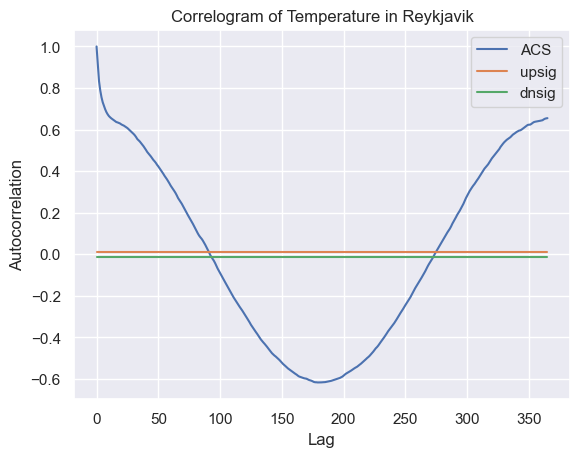

/tmp/ipykernel_19882/1577828388.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)


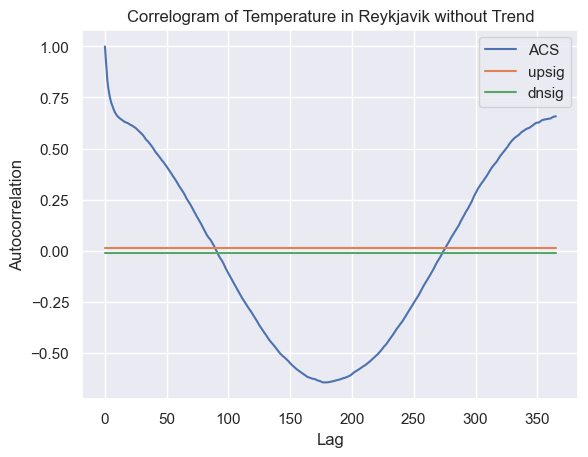

/tmp/ipykernel_19882/1577828388.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)


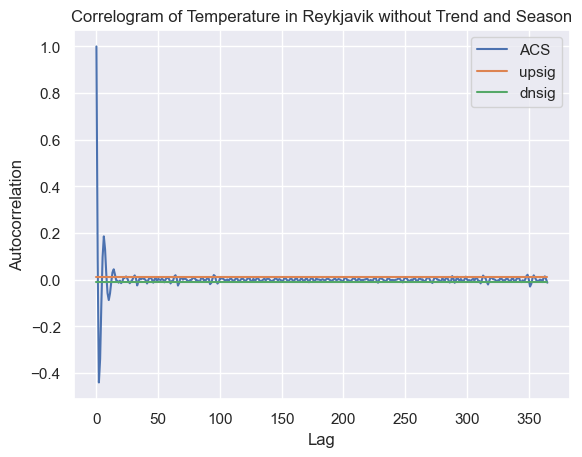

In [14]:
# Get autocorrelation of temp_mean
def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(np.abs(N))
        

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie)

def correlogram(timeserie,maxT,twoside=False):
    N=timeserie.size
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            corrl[i+maxT]=autocoef(timeserie,i)
            if i>0:
                corrl[maxT-i]=corrl[i+maxT]
        else:
            corrl[i]=autocoef(timeserie,i)
    d = {'ACS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

correlogram(temp_mean,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Temperature in Reykjavik')
plt.show()

# Autocorrelation of temp_mean without trend
correlogram(temp_mean_no_trend,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Temperature in Reykjavik without Trend')
plt.show()

# Autocorrelation of temp_mean without trend and season
correlogram(temp_mean_no_trend_no_season,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Temperature in Reykjavik without Trend and Season')
plt.show()

# Stationarity Assessment

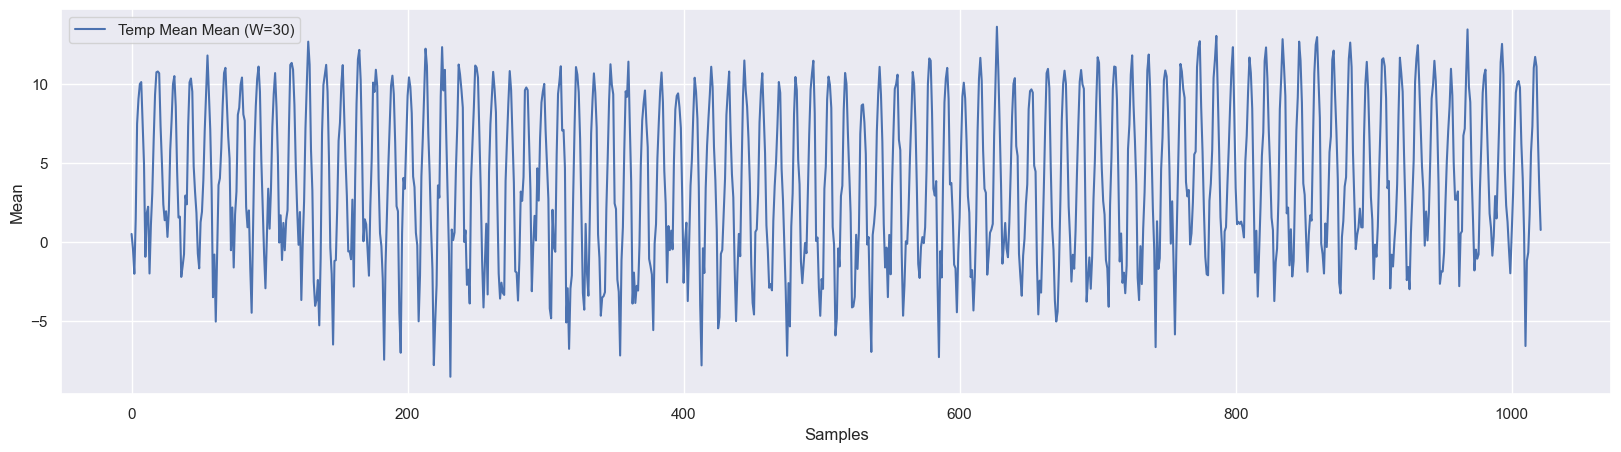

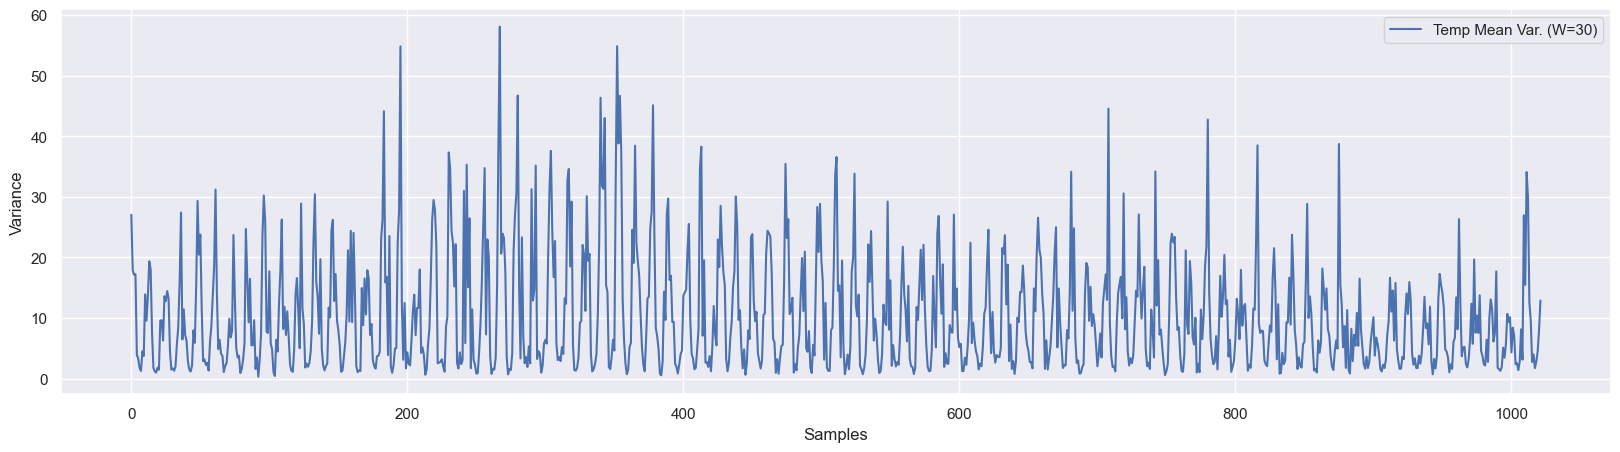

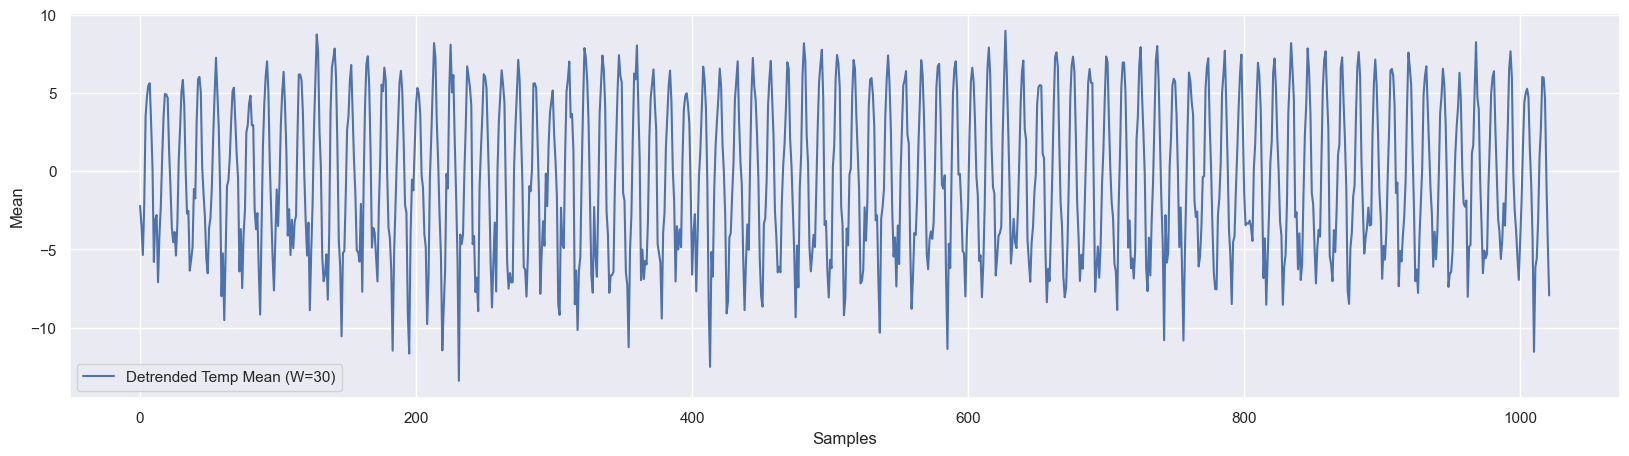

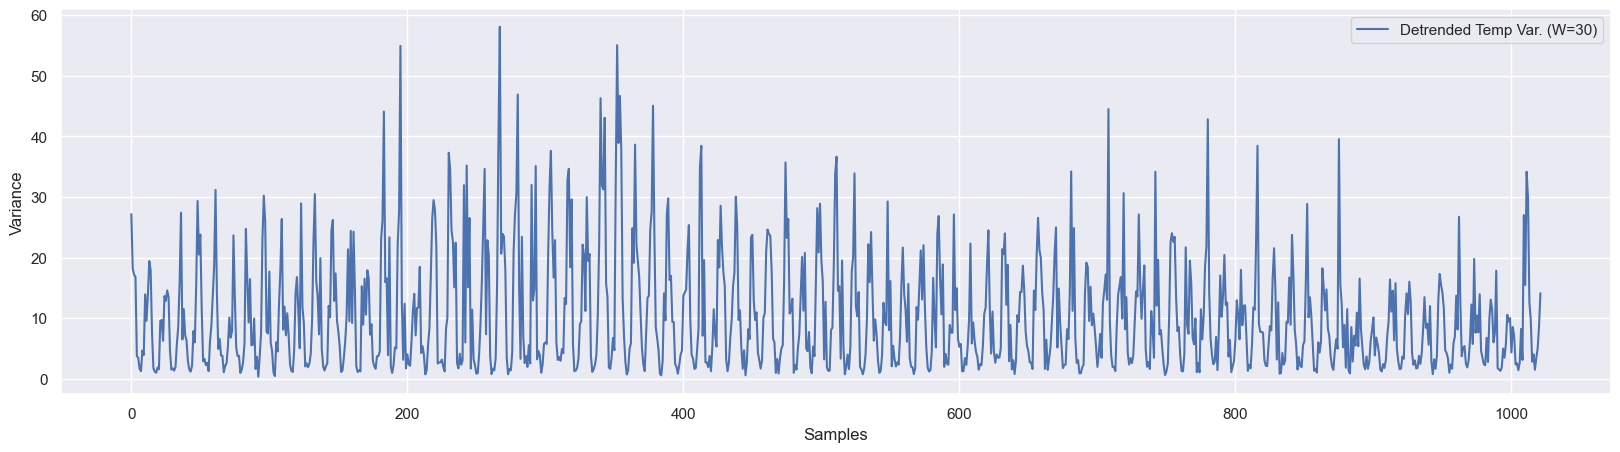

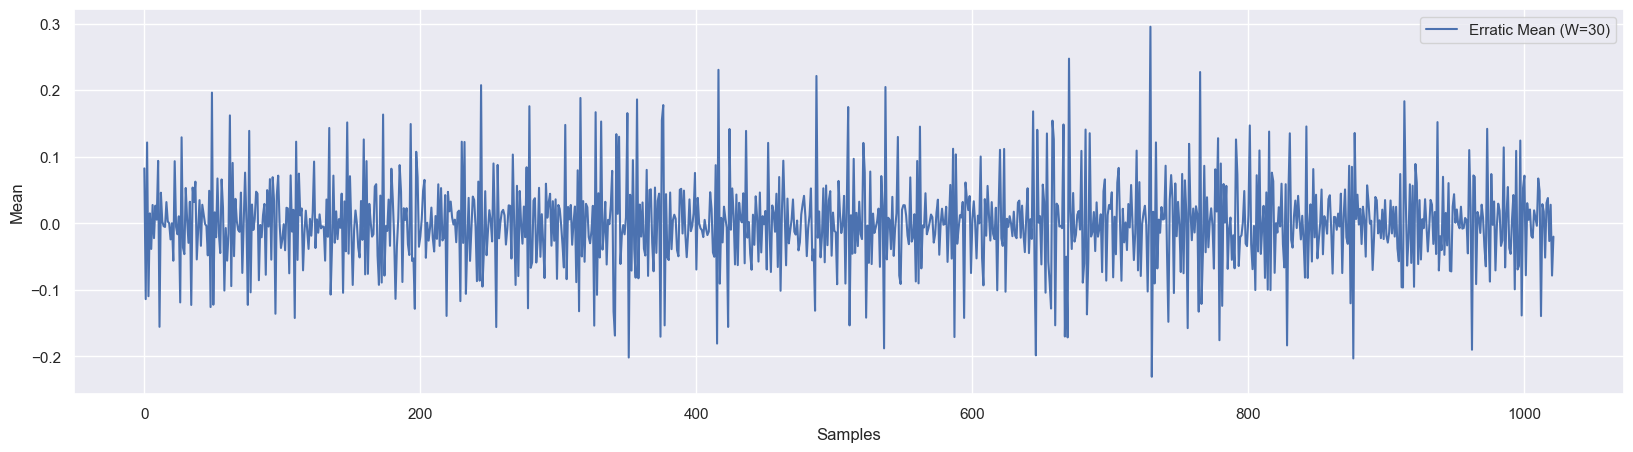

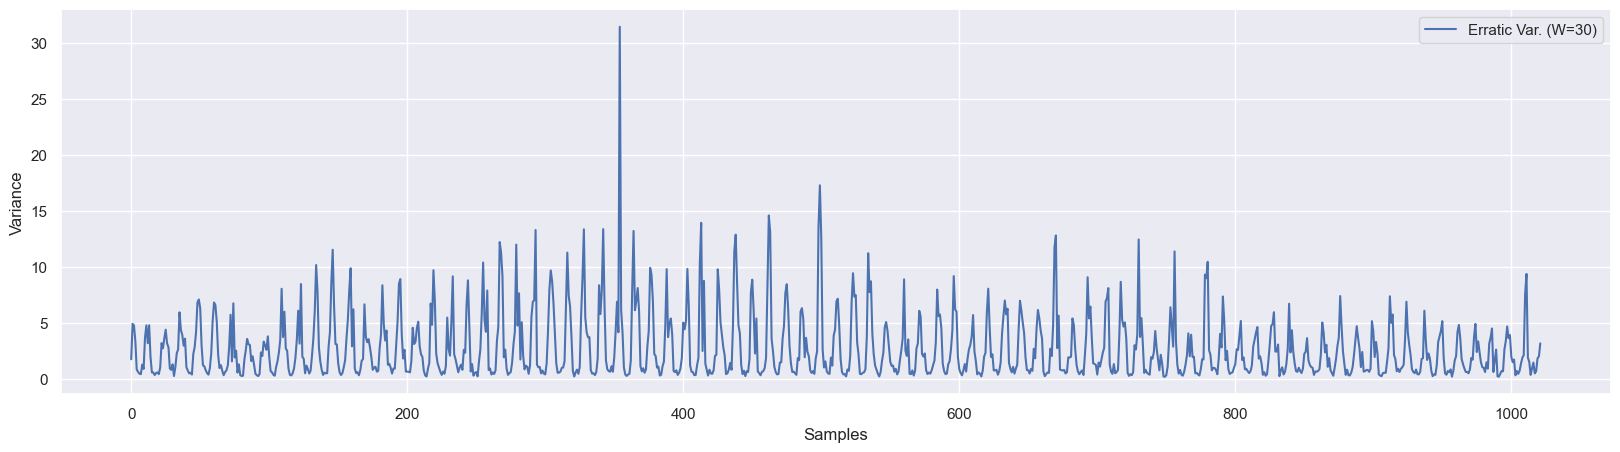

In [44]:
def meanvarWtime(timeseries,W=2):
    Nwin=int(np.floor(timeseries.size/W))
    vals=timeseries.to_numpy()
    vals=vals[0:int(Nwin*W)]
    mvals=vals.reshape((Nwin,W))
    return {'mu':np.mean(mvals,axis=1),'var':np.var(mvals,axis=1)}

fig, ax = plt.subplots(figsize=(20, 5))
Win=30 #Compute mean 
meanRandSeries=meanvarWtime(temp_mean,W=Win)['mu']
meanTS=pd.Series(data=meanRandSeries,index=np.array(range(meanRandSeries.size)),name="Temp Mean Mean (W="+str(Win)+")")
meanTS.plot(xlabel="Samples",ylabel="Mean",legend=True,ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
varRandSeries=meanvarWtime(temp_mean,W=Win)['var']
varTS=pd.Series(data=varRandSeries,index=np.array(range(varRandSeries.size)),name="Temp Mean Var. (W="+str(Win)+")")
varTS.plot(xlabel="Samples",ylabel="Variance",legend=True,ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
meanRandSeries=meanvarWtime(temp_mean_no_trend,W=Win)['mu']
meanTS=pd.Series(data=meanRandSeries,index=np.array(range(meanRandSeries.size)),name="Detrended Temp Mean (W="+str(Win)+")")
meanTS.plot(xlabel="Samples",ylabel="Mean",legend=True,ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
varRandSeries=meanvarWtime(temp_mean_no_trend,W=Win)['var']
varTS=pd.Series(data=varRandSeries,index=np.array(range(varRandSeries.size)),name="Detrended Temp Var. (W="+str(Win)+")")
varTS.plot(xlabel="Samples",ylabel="Variance",legend=True, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
meanRandSeries=meanvarWtime(temp_mean_no_trend_no_season,W=Win)['mu']
meanTS=pd.Series(data=meanRandSeries,index=np.array(range(meanRandSeries.size)),name="Erratic Mean (W="+str(Win)+")")
meanTS.plot(xlabel="Samples",ylabel="Mean",legend=True, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
varRandSeries=meanvarWtime(temp_mean_no_trend_no_season,W=Win)['var']
varTS=pd.Series(data=varRandSeries,index=np.array(range(varRandSeries.size)),name="Erratic Var. (W="+str(Win)+")")
varTS.plot(xlabel="Samples",ylabel="Variance",legend=True, ax=ax)
plt.show()


# Statistic Test ADFuller

ADF Statistic: -13.495728
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


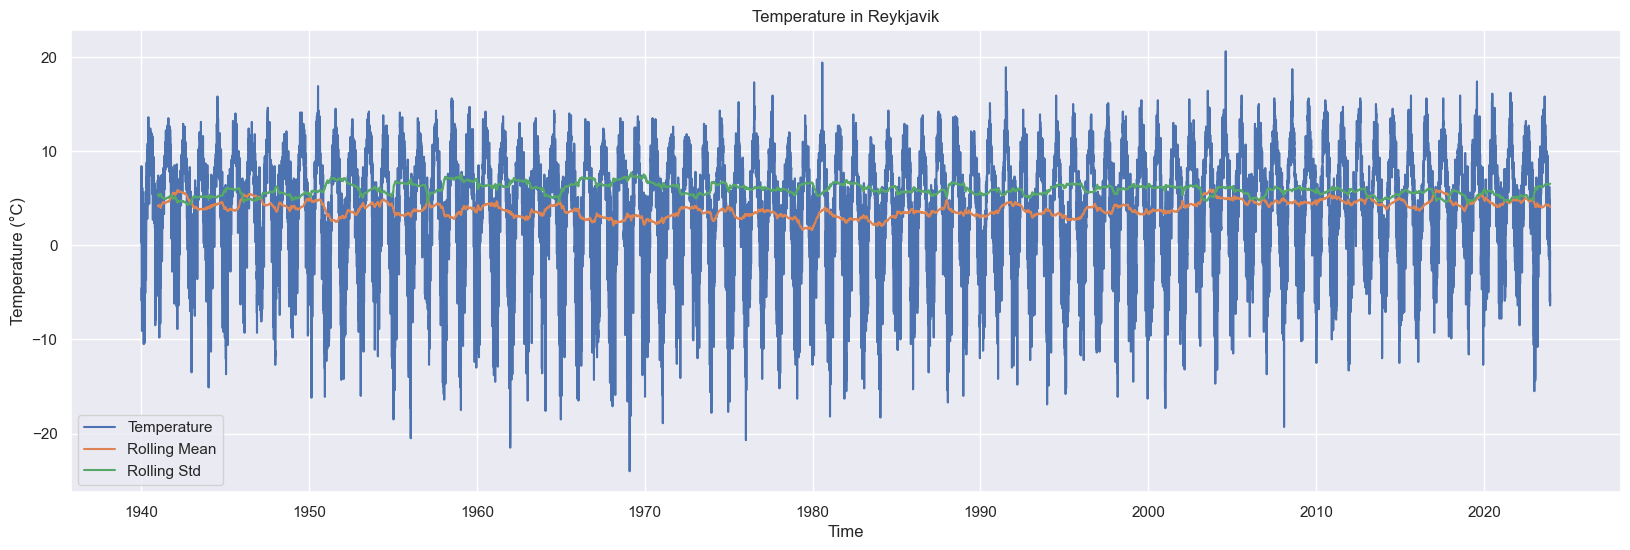

In [45]:
# Check if the time series is stationary
result = st.adfuller(temp_mean)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
# print results
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# Rolling mean and standard deviation
plt.figure(figsize=(20, 6))
plt.plot(time, temp_mean, label='Temperature')
plt.plot(time, temp_mean.rolling(window=365).mean(), label='Rolling Mean')
plt.plot(time, temp_mean.rolling(window=365).std(), label='Rolling Std')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.show()


/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_30745/351742765.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = st.kpss(temp_mean)


KPSS Statistic: 0.215805
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


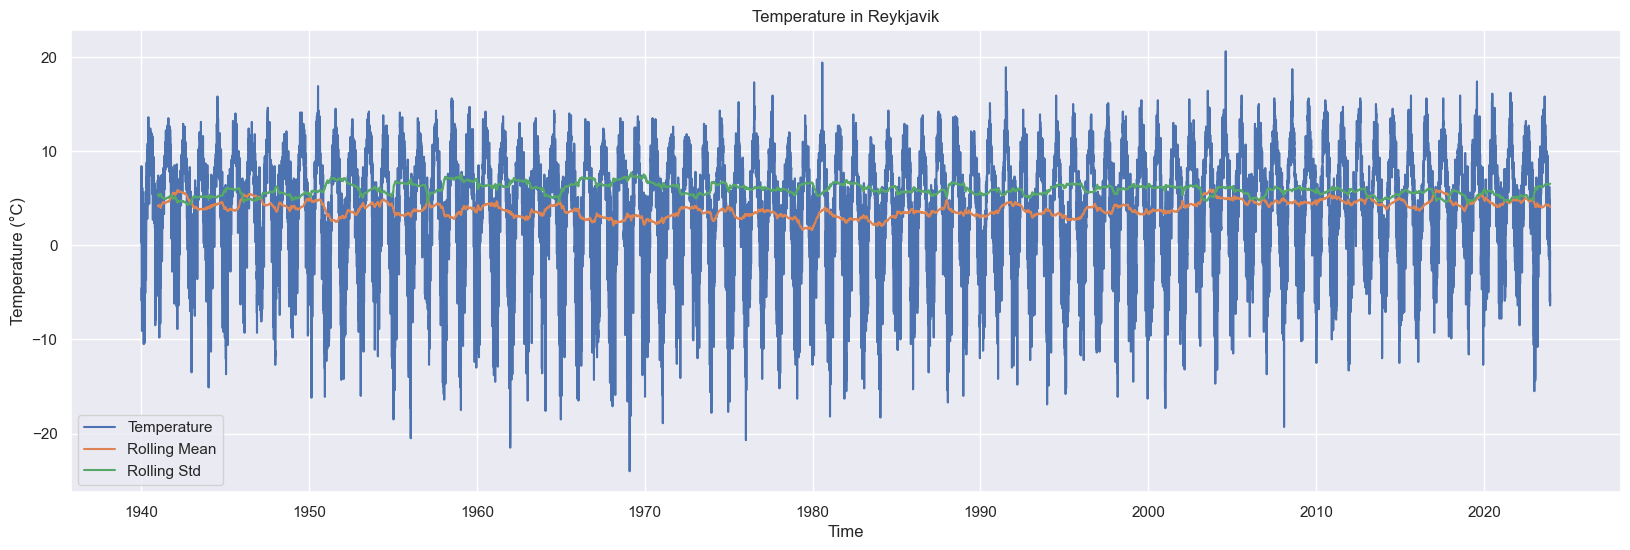

In [46]:
# apply KPSS test 
result = st.kpss(temp_mean)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
# print results
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

#plot
plt.figure(figsize=(20, 6))
plt.plot(time, temp_mean, label='Temperature')
plt.plot(time, temp_mean.rolling(window=365).mean(), label='Rolling Mean')
plt.plot(time, temp_mean.rolling(window=365).std(), label='Rolling Std')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.show()


# SARIMA

We use SARIMA, as our data is non-stationary and also includes alot of seasonality.

For SARIMA implementation we follow the folloing order of processing : 
1. Evaluate the order of the model.
2. Remove the trend to get p value 
3. Plot the autocorrelation
4. to get the D component which is the seasonaly differencing order
 -> we get the 
    d=1 Trend, D=1 seasonality order ... for this usually we start with D=1
    S=360 cause the visible seasonality cycles are yearly .
5. to get q, we look at the samples destribuition in the partial autocorrelation and see at what point do we start to consider Zero autocorrleation, that point would be q.
6. Q = 1 in the class example cause it enters the missconfidance zone right after the first s =12 


-->   SARIMA (p,d,q) x (P,D,Q)


1098    -1.995300e+01
1099    -4.913250e+01
1100    -6.206305e+01
1101    -6.187552e+01
1102    -6.440554e+01
             ...     
30655    6.714085e+06
30656    6.713984e+06
30657    6.713800e+06
30658    6.713553e+06
30659    6.713206e+06
Name: SARIMA(2,1,2)X(2,1,2)365, Length: 29562, dtype: float64


Text(0, 0.5, 'Autocorrelation')

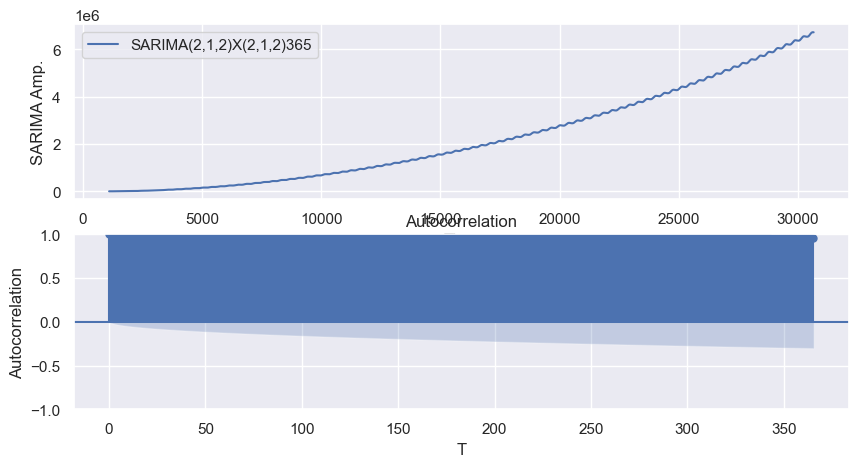

In [ ]:
def SARIMA(data, acoefs,d,mcoefs,Acoefs,D,Mcoefs,s,N,noise=1):
    if d>0:
        d1=np.array([-1,1])
        dpoly=d1
        if d>1:
            for i in range(d):
                dpoly=np.convolve(dpoly,d1)
        dpoly=np.flip(dpoly)
    else:
        dpoly=np.array([1])
    
    if D>0:
        D1=np.concatenate((np.array([-1]),np.zeros(s-1),np.array([1])),axis=0)
        Dpoly=D1
        if D>1:
            for i in range(D):
                Dpoly=np.convolve(Dpoly,D1)
        Dpoly=np.flip(Dpoly)
    else:
        Dpoly=np.array([1])
    
    Ac=np.zeros(Acoefs.size*s+1)
    k=0
    for i in range(s,Acoefs.size*s+1,s):
        Ac[i]=-Acoefs[k]
        k=k+1
    Ac[0]=1
    
    ac=np.zeros(acoefs.size+1)
    k=0
    for i in range(1,acoefs.size+1):
        ac[i]=-acoefs[k]
        k=k+1
    ac[0]=1
    
    Mc=np.zeros(Mcoefs.size*s+1)
    k=0
    for i in range(s,Mcoefs.size*s+1,s):
        Mc[i]=Mcoefs[k]
        k=k+1
    Mc[0]=1
    
    mc=np.zeros(mcoefs.size+1)
    k=0
    for i in range(1,mcoefs.size+1):
        mc[i]=mcoefs[k]
        k=k+1
    mc[0]=1
    
    Xcoef=np.convolve(np.convolve(np.convolve(ac,Ac),dpoly),Dpoly)
    Zcoef=np.convolve(mc,Mc)
    
    mx_coefs=max(Xcoef.size,Zcoef.size)
    Z=data*np.sqrt(noise)
    SARIMA=np.zeros(N)
    k=0
    for i in range(mx_coefs-1,N):
        for j in range(Xcoef.size-1):
            SARIMA[i]=SARIMA[i]-SARIMA[i-j-1]*Xcoef[j+1]
        SARIMA[i]=SARIMA[i]+Z[i]
        for j in range(Zcoef.size-1):
            SARIMA[i]=SARIMA[i]+Z[i-j-1]*Zcoef[j+1]
    strname="SARIMA("+str(acoefs.size)+","+str(d)+","+str(mcoefs.size)+")X("+str(Acoefs.size)+","+str(D)+","+str(Mcoefs.size)+")"+str(s)
    return pd.Series(data=SARIMA[mx_coefs-1:],index=np.array(range(mx_coefs-1,N,1)),name=strname)


N = 365*num_years # number of samples
acoefs = np.array([0.5, -0.4]) # AR coefficients - Phi
d = 1 # differencing order
mcoefs = np.array([0.5, -0.4]) # MA coefficients - Theta
Acoefs = np.array([0.5, -0.4]) # seasonal AR coefficients - Phi
D = 1 # seasonal differencing order
Mcoefs = np.array([0.5, -0.4]) # seasonal MA coefficients - Theta
s = 365 # seasonal period

# Generate SARIMA time series
SARIMA_series = SARIMA(temp_mean,acoefs, d, mcoefs, Acoefs, D, Mcoefs, s, N, noise=1)
fig, axs=plt.subplots(2,figsize=(10,5))
SARIMA_series.plot(ax=axs[0],legend=True,xlabel="Time",ylabel="SARIMA Amp.")
plot_acf(SARIMA_series,ax=axs[1], lags=s)
plt.xlabel("T")
plt.ylabel("Autocorrelation")  

# plot 

1. Estimate the model order

Text(84.875, 0.5, 'Autocorrelation')

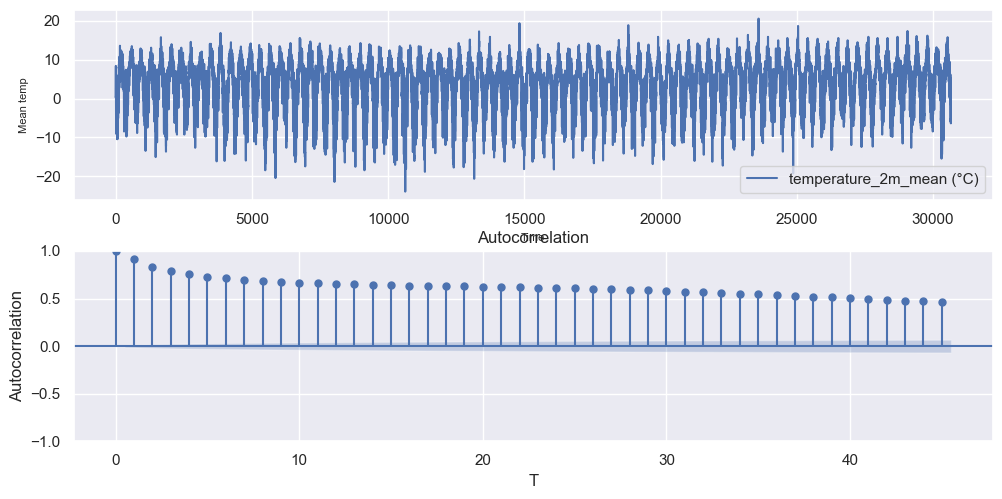

In [48]:
temp_mean = temp_mean[:N]
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
temp_mean.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean temp',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(temp_mean, ax=axs[1])
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

Althoug the TS doesn't show much Trend it's important the remove even the slight trend that might occur

Text(84.875, 0.5, 'Autocorrelation')

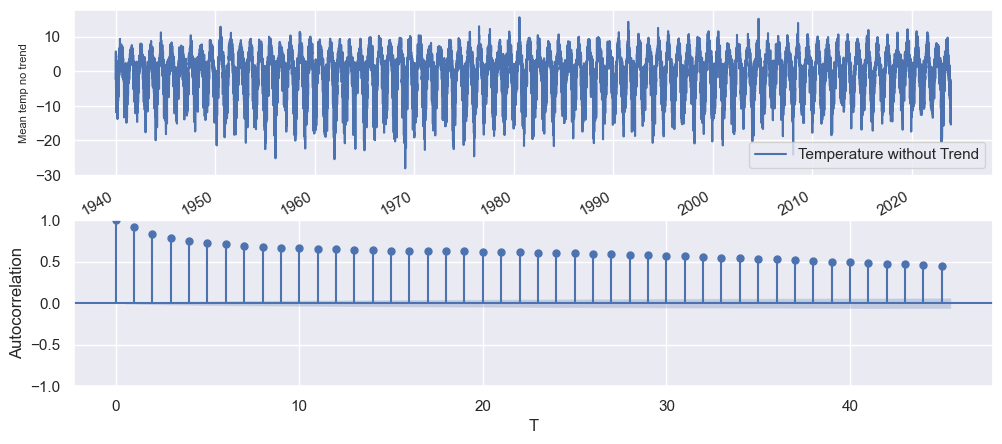

In [49]:
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
temp_mean_no_trend.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean temp no trend',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(temp_mean_no_trend.dropna(),ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

Text(84.875, 0.5, 'Autocorrelation')

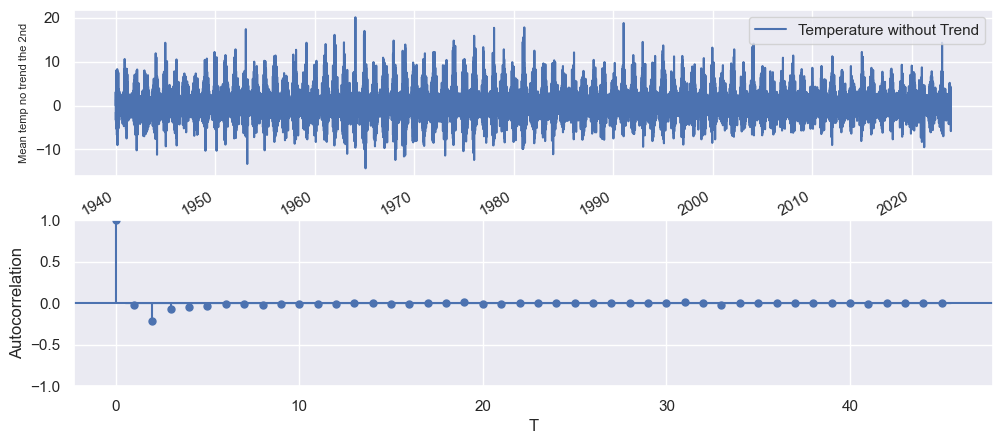

In [50]:
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
# diffrencing again the no trend TS so it acutally has no trend
temp_mean_no_trend_2nd_order = temp_mean_no_trend.diff().dropna()
temp_mean_no_trend_2nd_order.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean temp no trend the 2nd',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(temp_mean_no_trend_2nd_order.dropna(),ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

Trend disapears and we define d=2, because we needed 2 differencing operations to remove trend. Now the autocorrelations highlight a possible seasonal pattern at each 365 samples. So $S=365$ and lets implement a seasonal differencing operation:

Text(85.0, 0.5, 'Par. Autocorrelation')

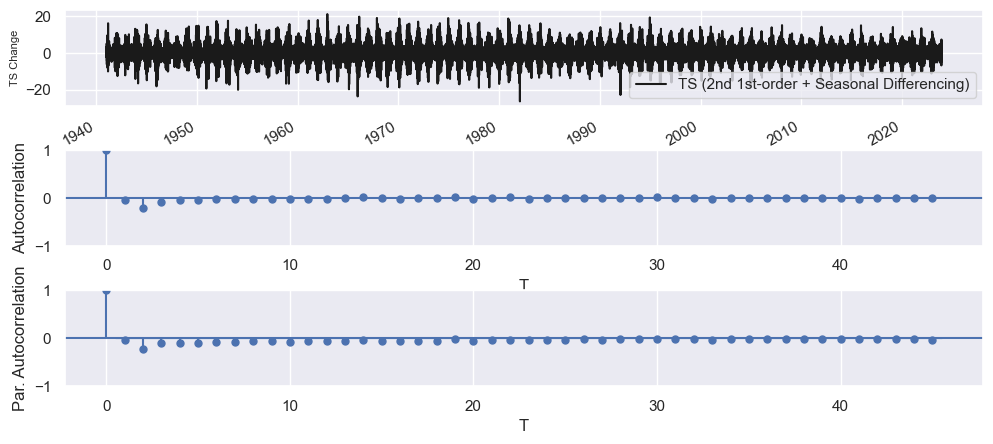

In [54]:
fig, axs=plt.subplots(3,figsize=(10,5))
fig.tight_layout()

temp_mean_no_trend_2nd_order_no_season =temp_mean_no_trend_2nd_order.diff(365)
temp_mean_no_trend_2nd_order_no_season.name="TS (2nd 1st-order + Seasonal Differencing)"
temp_mean_no_trend_2nd_order_no_season.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('TS Change',fontdict={'fontsize':8})
axs[0].set_xlabel('Time ',fontdict={'fontsize':8})

plot_acf(temp_mean_no_trend_2nd_order_no_season.dropna(),ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

plot_pacf(temp_mean_no_trend_2nd_order_no_season.dropna(),ax=axs[2],title='')
axs[2].set_xlabel("T")
axs[2].set_ylabel("Par. Autocorrelation")

Here we can confirm the stationrity with ADF.How ever ADF never worked so .. 

The ADF unit root test confirms stationarity. So, until now we determined $d=2$, $D=1$ and $S=365$. Let's now determine the $\phi(B)$, $\theta(B)$, $\Phi(B^{365})$ and $\Theta(B^{365})$ orders. To determine the orders of $\phi(B)$, $\theta(B)$ we represent the ACF and PACF until $S-1$:

Text(84.875, 0.5, 'Partial Autocorrelation')

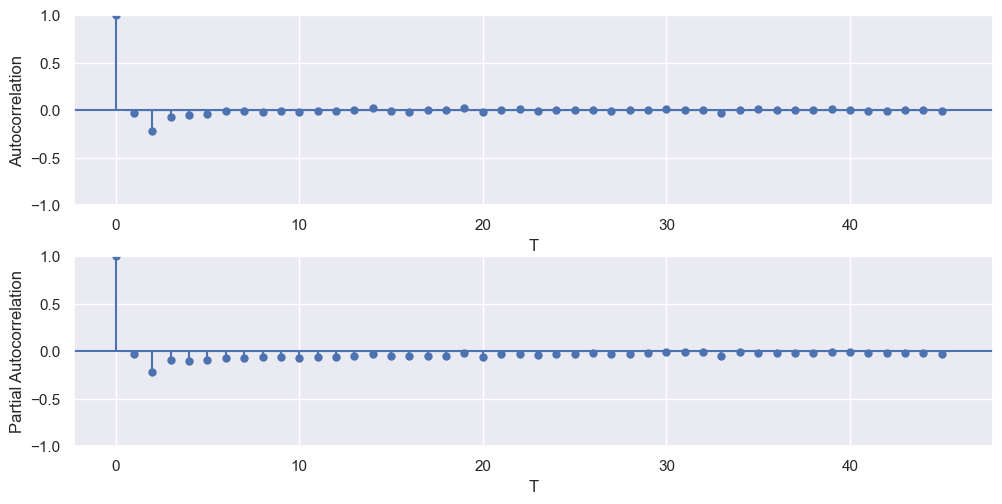

In [55]:
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()

plot_acf( temp_mean_no_trend_2nd_order_no_season.dropna(), ax = axs[0], title = '')
axs[0].set_xlabel('T')
axs[0].set_ylabel('Autocorrelation')

plot_pacf( temp_mean_no_trend_2nd_order_no_season.dropna(), ax = axs[1], title = '')
axs[1].set_xlabel('T')
axs[1].set_ylabel('Partial Autocorrelation')

Following the ACF we define $q=2$. According to PACF we define $p=2$. To infer about the orders of $\Phi(B^{365})$ and $\Theta(B^{365})$ we sample the ACF and PACF at each $S=365$ lag:

Text(84.875, 0.5, 'Par. Autocorrelation')

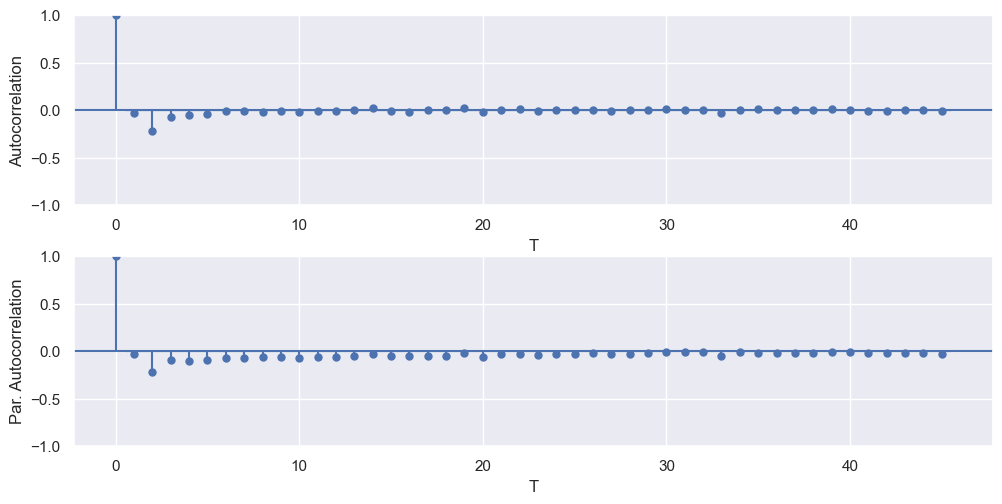

In [79]:
# lags should follow a understandable range .. in the class it was (0,40,12)
# cause the seaonality repreats in 12 samples, in our case its 365 , for so  i tried the following range  
# lags  = range(0, 365*num_years,365) ... but it doesn't work 
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
plot_acf( temp_mean_no_trend_2nd_order_no_season.dropna(),ax = axs[0], title = '')
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")


plot_pacf( temp_mean_no_trend_2nd_order_no_season.dropna(), ax = axs[1], title = '')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Par. Autocorrelation")


In [81]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(temp_mean, order=(2, 2, 2), seasonal_order=(1, 1, 1, 365))
fit = model.fit()
fit.summary()
print("Fitted model AIC="+str(fit.aic))

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.plot(fit.resid)
print("Residuals mean="+str(fit.resid.mean()))

plt.figure()
plot_acf(fit.resid,title="")
plt.xlabel("T")
plt.ylabel("ACS")

ac = acf(fit.resid,nlags = 500, ftt  =False)
plt.figure()
plt.hist(ac[1:],bins=30,density=True,label='ACS(T>0) Hist.')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()
